In [53]:
# import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.preprocessing import image
from mlxtend.plotting import plot_confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.layers import Dense, Conv2D, Dropout, Flatten, Activation
from keras.layers import SeparableConv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
# define some variables for later usage
epochs = 10
img_size = 150
batch_size = 32
drct_path = '/content/drive/MyDrive/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning-master'

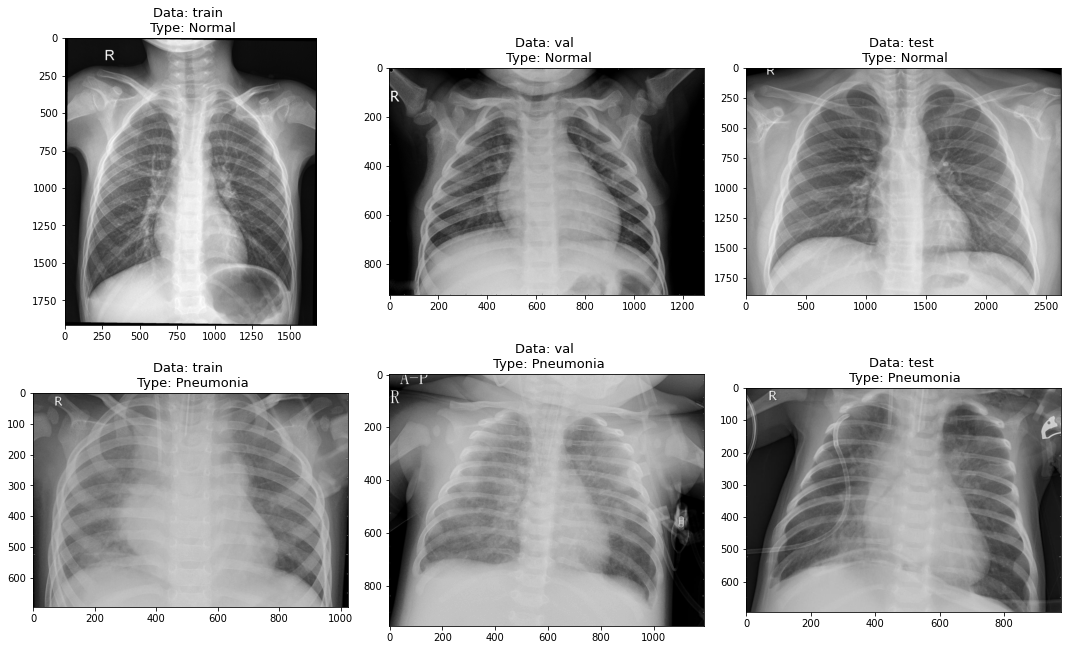

In [56]:
fig, ax = plt.subplots(2, 3, figsize = (15, 9))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = drct_path +'/'+ _set
    ax[i].imshow(plt.imread(set_path + '/NORMAL/' + os.listdir(set_path + '/NORMAL')[0]), cmap = 'gray')
    ax[i].set_title('Data: {} \n Type: Normal'.format(_set), fontsize = 13)
    ax[i+3].imshow(plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA')[0]), cmap = 'gray')
    ax[i+3].set_title('Data: {} \n Type: Pneumonia'.format(_set), fontsize = 13)

In [57]:
# checking the shape of some images from both types
img_n = plt.imread(set_path + '/NORMAL/' + os.listdir(set_path + '/NORMAL')[0])
img_p = plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA')[0])
print(f'Normal size:  {img_n.shape}')
print(f'Pneumonia size:  {img_p.shape}')

Normal size:  (1893, 2624)
Pneumonia size:  (696, 976)


In [58]:
# checking the no. of validating images for each type
print ('Normal counts: {}'.format(len(os.listdir(drct_path + '/'+'val/NORMAL/'))))
print ('Pneumonia counts: {}'.format(len(os.listdir(drct_path + '/'+'val/PNEUMONIA/'))))

Normal counts: 8
Pneumonia counts: 8


In [59]:
# checking the no. of test images for each type
print ('Normal counts: {}'.format(len(os.listdir(drct_path + '/'+ 'test/NORMAL/'))))
print ('Pneumonia counts: {}'.format(len(os.listdir(drct_path +'/'+ 'test/PNEUMONIA/'))))

Normal counts: 234
Pneumonia counts: 390


In [60]:
# checking the no. of training images for each type
print ('Normal counts: {}'.format(len(os.listdir(drct_path +  '/'+'train/NORMAL/'))))
print ('Pneumonia counts: {}'.format(len(os.listdir(drct_path + '/'+ 'train/PNEUMONIA/'))))

Normal counts: 1341
Pneumonia counts: 3875


As the above script shows that the dataset is highly imbalanced as the number of pneumonia classes is lot more than the number of normal classes. 

We can handle this imbalanced issue by applying data augmentation technique to enlarge the size of the minority class (Normal images) in order to optimise the performance of the model and avoid overfitting.

For the data augmentation, we will do:

1.   Rescale pixel values from the range of 0-255 to the range 0-1.
2.   Randomly Zoom by 30% some training images.
3.   Randomly flip images vertically.


In [61]:
# ImageDataGenerator allows the network to "see" more diversified,
# but still representative, data points during training
train_datagen = ImageDataGenerator(rescale = 1./255, # transform pixeles from range 0-255 to range 0-1
                                   zoom_range = 0.3, # randomly zoom image 
                                   vertical_flip = True) # randomly flip images

# load a mini batch of images directly from the source folder then convert them into a vector of attributes
training_set = train_datagen.flow_from_directory(directory = drct_path + '/'+'train',
                                                 batch_size = batch_size,
                                                 target_size = (img_size, img_size),
                                                 shuffle = True,
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [62]:
# prepare test data
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(directory = drct_path + '/'+'test',
                                            batch_size = batch_size,
                                            target_size = (img_size, img_size),
                                            shuffle = True,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.


**Building the Model**

We are going to build a CNN that has 5 Convolution layers. After each convolution, we will add a Pooling layer using max-pooling. After the final convolutional layer, we will add some Fully Connected layers after that flattening step, these nodes will act as an input layer to these fully-connected layers. 

Dense is the function to add a fully connected layer, "units" is where we define the number of nodes that should be present in this hidden layer. The last Fully Connected layer or the output layer has only 1 "unit" because it needs to predict in binary (if someone has pneumonia or not).

In [63]:
model = Sequential()

# 1st conv
model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape = (img_size, img_size, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

# 2nd conv
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

# 3rd conv
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# 4th conv
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

# 5th conv
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

# fully connected layer
model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate = 0.7))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.3))

# output layer
model.add(Dense(units = 1, activation = 'sigmoid'))

In [64]:
#complete summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_16 (Separab (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_17 (Separab (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_8 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 37, 37, 32)       

In [65]:
# compiling the sequential model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Before start training the mode we are  going to define callbacks such as ModelCheckpoint to save a copy of the best performing model only when an epoch that improves the metrics ends, and EarlyStopping to prevent overfitting especially when difference between training and validation error) starts to increase

In [66]:
# callbacks
checkpoint = ModelCheckpoint(filepath = 'best_weights.hdf5', save_best_only = True, save_weights_only = True)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 2, mode = 'max')
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 1, mode = 'min')

In [67]:
# fit the data to the cnn model
cnn = model.fit_generator(training_set,
                          epochs = epochs,
                          steps_per_epoch = training_set.samples // batch_size,
                          validation_data = test_set,
                          validation_steps = test_set.samples // batch_size,
                          callbacks = [checkpoint, lr_reduce])   

Epoch 1/10
163/163 [==============================] - 84s 507ms/step - loss: 0.4780 - accuracy: 0.7698 - val_loss: 1.0213 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 82s 505ms/step - loss: 0.3004 - accuracy: 0.8618 - val_loss: 1.0202 - val_accuracy: 0.6266
Epoch 3/10
163/163 [==============================] - 82s 504ms/step - loss: 0.2652 - accuracy: 0.8944 - val_loss: 1.6079 - val_accuracy: 0.6234
Epoch 4/10
163/163 [==============================] - 82s 505ms/step - loss: 0.2489 - accuracy: 0.9148 - val_loss: 0.9276 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - 82s 505ms/step - loss: 0.2341 - accuracy: 0.9098 - val_loss: 0.5629 - val_accuracy: 0.7171

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/10
163/163 [==============================] - 83s 507ms/step - loss: 0.1787 - accuracy: 0.9337 - val_loss: 0.2450 - val_accuracy: 0.9013
Epoch 7/10
163/163 [=============================

Predicted : Pnuemonia
Actual : Pnuemonia


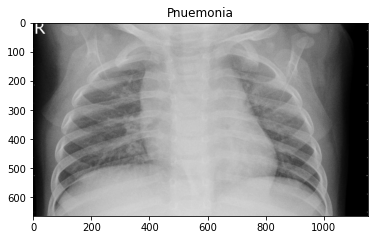

In [74]:
#lets see how it did on the data provided
from keras.preprocessing import image
rand_img = np.random.randint(0, len(os.listdir(drct_path +'/'+ 'val/PNEUMONIA/')))
rand_img_path = drct_path + '/'+'val/PNEUMONIA/' + os.listdir(drct_path +'/'+ 'val/PNEUMONIA/')[rand_img]

img = plt.imread(rand_img_path)
img = cv2.resize(img, (img_size, img_size))
img = np.dstack([img, img, img])
img = img.astype('float32') / 255
result = model.predict(np.expand_dims(image.img_to_array(img), axis = 0))  

if result[0][0] >0.5:
  prediction = 'Pnuemonia'
else:
  prediction = 'Normal'
  
print(f'Predicted : ' + prediction)
print ('Actual : Pnuemonia')

image = plt.imread(rand_img_path)
plt.imshow(image)
plt.title('Pnuemonia')
plt.imshow(image, cmap = 'gray')


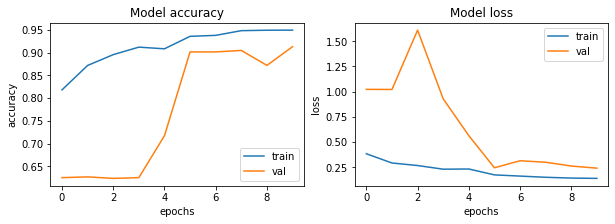

In [75]:
#visualizing the loss and accuracy loss
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(cnn.history[met])
    ax[i].plot(cnn.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [76]:
test_data = []
test_labels = []

for title in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(drct_path +'/'+  'test' + title)):
            img = plt.imread(drct_path + '/'+ 'test' + title + img)
            img = cv2.resize(img, (img_size, img_size))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if title == '/NORMAL/':
                label = 0
            elif title == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)
# get predictions
preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
# get the confusion matrix
mat = confusion_matrix(test_labels, np.round(preds))

In [80]:
# calculate precision and recall
tn, fp, fn, tp = mat.ravel()
print('Test Metrics:')
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

Test Metrics:
Accuracy: 91.34615384615384%
Precision: 89.25233644859813%
Recall: 97.94871794871794%
F1-score: 93.39853300733496


In [81]:
print('Train Metric:')
print('Train accuracy: {}%'.format(np.round(cnn.history['accuracy'][-1]*100, 2)))

Train Metric:
Train accuracy: 94.92%
